##### Copyright 2025 Google LLC.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Outfit Assistant 🧤


<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Outfit_Assistant.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>


#### The notbook is the implementation of an outfit assistant that uses Gemini's multimodality to recommend outfits based on the following factors:

- User's style preference,
- Occasion, and
- Weather data

The `style preference` and the `occasion` would be entered by the user and to get the weather data, the notebook uses the external API by [OpenWeather](https://openweathermap.org/).

_Note: You can get the weather API key using this link: [OpenWeather Website Link](https://openweathermap.org/)_


In [26]:
%pip install -U -q "google-genai" # Install the Python SDK

In [27]:
from google import genai
genai.__version__

'1.9.0'

#### Importing the required packages


In [28]:
import requests
import re
from PIL import Image, ImageOps
from IPython.display import display
import os

## Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](../quickstarts/Authentication.ipynb) quickstart for an example.


In [29]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
# Genai client
client = genai.Client(api_key=GOOGLE_API_KEY)

## Optional:

To run the following cell, make sure your API key is stored in a Colab secret named `WEATHER_API`.

This key is required to fetch real-time weather data.

If you don't have an API key yet, you can get one here: [OpenWeather Website](https://openweathermap.org/).

_You can also skip this step, but note that the `get_weather` function will not work without the API key._


In [78]:
WEATHER_API = ""
try:
    WEATHER_API = userdata.get('WEATHER_API')
except:
    WEATHER_API = ""

## Helper Functions

This section contains various helper functions that would be used in the program.

- `get_weather`: Gets the weather information based on the provided city and country

- `download_images`: Fetches the image using the list of links provided and stores them in the provided directory.

- `get_pil_image_objects`: Converts the downloaded images to PIL objects to pass to the Gemini

- `show_suggested_outfit`: Shows all the clothing items that have been recommended by Gemini.

- `show_all_images`: Shows all the images in the form of collage using the PIL image objects


In [117]:
def get_weather(city: str, country: str = "") -> str:
  """
  Gets the weather information based on the provided city and country

  Args:
    city (str) = The city name.
    country (str) = The country name (optional).

  To find the country code use this link:
    https://developer.accuweather.com/countries-by-region

  Returns:
    weather_info (str) =  The weather information for the given location.
  """
  location = city
  if country != "":
    location = f"{city}, {country}"
  try:
    response = requests.get(f"https://api.openweathermap.org/data/2.5/weather?q={location}&APPID={WEATHER_API}")
    return response.text
  except Exception as e:
    print("---Exception has occurred in `get_weather`---")
    print(e)
    return ""

def download_images(image_links: list[str], output_dir:str = "outfit_assistant_images") -> None:
    """
    Fetches the image using the `image_links` and stores them into `output_dir`

    Args:
        image_links: list[str] = List of cloth image links
        output_dir: str = Name of the output directory where the images would be stored. Defaults to `outfit_assistant_images`

    Returns:
        None
    """

    # Creates a new directory if it does not exists
    os.makedirs(output_dir, exist_ok=True)

    # Download and save each image
    for index, url in enumerate(image_links):
        try:
            response = requests.get(url)
            response.raise_for_status()

            # Get image extension from URL or content-type
            extension = url.split('.')[-1].split('?')[0]
            if extension not in ['jpg', 'jpeg', 'png']:
                extension = 'jpg'

            filename = f"image_{index + 1}.{extension}"
            filepath = os.path.join(output_dir, filename)

            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Saved: {filename}")

        except requests.RequestException as e:
            print(f"Failed to download image {index + 1}: {e}")

def get_pil_image_objects(input_dir: str = "outfit_assistant_images") -> list:
    """
    Converts the downloaded images to PIL objects to pass to the Gemini

    Args:
        input_dir: str = The directory name in which the images have been installed. Defaults to `outfit_assistant_images`

    Returns:
        List containing PIL image objects of all the downloaded images
    """
    # Initialize an empty list to store PIL image object
    image_objects = []

    # Supported image formats
    supported_extensions = ['.jpg', '.jpeg', '.png']

    # Iterate through the each file in the directory
    for filename in os.listdir(input_dir):
        if any(filename.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(input_dir, filename)
            try:
                # Ensure consistency (e.g., avoid RGBA or grayscale issues)
                img = Image.open(image_path).convert("RGB")
                image_objects.append(img)
                print(f"Loaded: {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    print(f"Total images loaded: {len(image_objects)}")
    return image_objects

def show_suggested_outfit(image_objects: list, image_numbers: list[int]) -> None:
    """
    Shows all the clothing items that have been recommended by Gemini.

    Args:
        image_objects: list = The list containing all the images' PIL objects generated using the `get_pil_image_objects`.

        image_numbers: list[int] = The list containing the image numbers recommended by Gemini. The index of the image in the list follows 1-based indexing.

    Returns:
        None as this function would just show the images using the PIL library
    """
    # Create a new image with width = sum of all images, height = max height
    # `i-1` because image_objects follows 0-based indexing
    images = [image_objects[i-1].copy() for i in image_numbers]
    thumbnail_size = (200, 200)
    thumbnails = [img.copy().resize(thumbnail_size) for img in images]

    total_width = thumbnail_size[0] * len(thumbnails)
    max_height = thumbnail_size[1]

    # Create new image to hold the collage
    collage = Image.new('RGB', (total_width, max_height))

    # Paste images side by side
    x_offset = 0
    for img in thumbnails:
        collage.paste(img, (x_offset, 0))
        x_offset += thumbnail_size[0]

    display(collage)


def show_all_images(image_objects: list) -> None:
    """
    Shows all the images in the form of collage using the PIL image objects

    Args:
        image_objects: list = The list containing all the images' PIL objects generated using the `get_pil_image_objects`.

    Returns:
        None as this function would just show the images using the PIL library
    """
    # Thumbnail size
    thumb_width = 256
    thumb_height = 256

    # Padding between each image
    padding = 20

    # Resize all images and add border
    thumbnails = []
    for img in image_objects:
        thumb = img.copy()
        thumb.thumbnail((thumb_width, thumb_height))
        thumb = ImageOps.expand(thumb, border=10, fill='white')
        thumbnails.append(thumb)

    # Calculate final image size
    total_width = sum(img.width for img in thumbnails) + padding * (len(thumbnails) - 1)
    max_height = max(img.height for img in thumbnails)

    # Create a blank canvas
    collage = Image.new('RGB', (total_width, max_height), color='white')

    # Paste thumbnails into the canvas
    x_offset = 0
    for thumb in thumbnails:
        collage.paste(thumb, (x_offset, 0))
        x_offset += thumb.width + padding

    # Display the collage
    display(collage)


## Main function - The program execution would happen here


In [119]:
# Links for the ai generated clothing items
clothing_image_links = [
    # Lowerwear image links
    "https://i.ibb.co/k2WXFvy5/image1.png",
    "https://i.ibb.co/4g2NkQnF/image2.jpg",
    "https://i.ibb.co/FkX3DGYN/image3.png",
    "https://i.ibb.co/6GVrm2Y/image4.jpg",
    "https://i.ibb.co/svgz8KR2/image5.png",
    "https://i.ibb.co/8D9pSvFt/image6.jpg",
    "https://i.ibb.co/bjX8nWLN/image7.jpg",
    "https://i.ibb.co/tT0WVwgV/image9.jpg",
    "https://i.ibb.co/HkqLfXm/image8.jpg",
    "https://i.ibb.co/Mk7jqBTH/image10.jpg",
    # Upperwear image links
    "https://i.ibb.co/dJr8nvys/clothing-item1.jpg",
    "https://i.ibb.co/rGZVFBKc/clothing-item2.jpg",
    "https://i.ibb.co/0PfxGYV/clothing-item3.jpg",
    "https://i.ibb.co/jPNGY6DK/clothing-item4.png",
    "https://i.ibb.co/DfHqDsRD/clothing-item5.jpg",
    "https://i.ibb.co/9m32nQd6/clothing-item6.png",
    "https://i.ibb.co/mF9np1f0/clothing-item7.jpg",
    "https://i.ibb.co/YBZW88Yh/clothing-item8.jpg",
    "https://i.ibb.co/hFC2xMtL/clothing-item9.png",
    "https://i.ibb.co/wFm03L4p/clothing-item10.jpg",
    "https://i.ibb.co/bg2kJp0P/clothing-item11.jpg",
    ]


#### Download all the images


In [120]:
download_images(image_links=clothing_image_links, output_dir="outfit_assistant_images")

Saved: image_1.png
Saved: image_2.jpg
Saved: image_3.png
Saved: image_4.jpg
Saved: image_5.png
Saved: image_6.jpg
Saved: image_7.jpg
Saved: image_8.jpg
Saved: image_9.jpg
Saved: image_10.jpg
Saved: image_11.jpg
Saved: image_12.jpg
Saved: image_13.jpg
Saved: image_14.png
Saved: image_15.jpg
Saved: image_16.png
Saved: image_17.jpg
Saved: image_18.jpg
Saved: image_19.png
Saved: image_20.jpg
Saved: image_21.jpg


#### Convert all the downloaded images into PIL image object and store them in a variable `image_objects`


In [121]:
image_objects = get_pil_image_objects(input_dir="outfit_assistant_images")

Loaded: image_12.jpg
Loaded: image_18.jpg
Loaded: image_19.png
Loaded: image_5.png
Loaded: image_6.jpg
Loaded: image_3.png
Loaded: image_8.jpg
Loaded: image_11.jpg
Loaded: image_17.jpg
Loaded: image_9.jpg
Loaded: image_2.jpg
Loaded: image_15.jpg
Loaded: image_4.jpg
Loaded: image_14.png
Loaded: image_20.jpg
Loaded: image_13.jpg
Loaded: image_1.png
Loaded: image_10.jpg
Loaded: image_7.jpg
Loaded: image_16.png
Loaded: image_21.jpg
Total images loaded: 21


#### Show all the downloaded images using the list of PIL image object


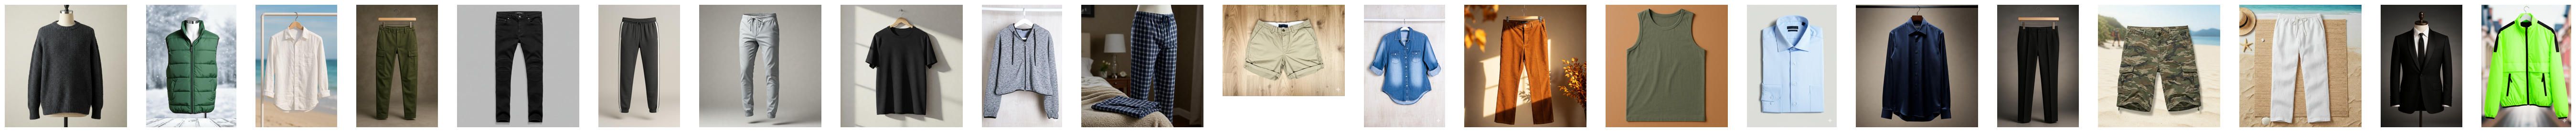

In [122]:
show_all_images(image_objects=image_objects)

#### main function


In [126]:
def main():
    try:
        user_preferences = input("✨ Enter your outfit preferences (e.g., casual, formal, sporty) or press Enter to skip: ").strip()

        if not user_preferences:
            print("🔎 Skipping outfit preferences...")

        while True:
            occasion = input("🎉 Enter the occasion (e.g., wedding, office, gym): ").strip()
            if occasion:
                break
            print("⚠️ Occasion cannot be empty. Please enter the occasion.")

        city = input("🌆 Enter your city to fetch the weather (or press Enter to skip): ").strip()
        country = input("🌍 Enter your country to fetch the weather (or press Enter to skip): ").strip()
        weather_data = ""

        # When no city and country has been added by the user
        if not city and not country:
            print("⛅ Skipping weather check...")
        # When no weather API has been provided
        elif not WEATHER_API:
            print("🚫 No WEATHER_API key found. Skipping weather check...")
        else:
            print("⛅ Scanning the skies for your weather update...")
            weather_data = get_weather(city=city, country=country)

        print("🧠 Gemini is putting together the perfect look for you...")

        prompt = f"""
            You are a fashion assistant who has a great sense of style.
            You will be presented with various set of clothing items that includes multiple upperwear and lowerwear clothing items.

            User preferences:
            <user_preferences>
            {user_preferences}
            </user_preferences>
            If the user_preferences is None in that case you would not account anything related to the user_preferences and use your general intelligence to recommend the outfit.

            The user wants an outfit for this occasion:
            <occasion>
            {occasion}
            </occasion>

            The occasion would always be provided by the user and you need to account that while recommending the outfit.

            The weather_data of the user's location is:
            <weather_data>
            {weather_data}
            </weather_data>

            If the weather_data is missing or has been fetched with incomplete or irrelevant weather data in that case you would not account weather_data while recommending the outfit. But if it has been provided then you would look at it and then use that as well while recommending the outfit.

            In the final response, do mention the outfit along with a description that would help the user know exactly what you are refering to without even looking at the image. This would help the user to identify the clothing item easily.  Do not mention anything related to the image number here.

            At the very end of the response, I want you to take the image numbers and add in the array like this,
            ```image_numbers: [1, 2, 3]```
            This array will be used by the program to get show the images related to the respective clothing item that you suggested. This would be used to show the image of the clothing item so make sure you provide the image number same as the ones you suggested.

            While generating the response, take gaps and pauses to answer the user query.
            Do not add anything irrelevant at the end or at the start of the response.
            If you find the instructions unclear, or any response mentioned by the user that you can not recommend any outfit for, in that case you can politely decline the request and then the image_numbers array that you add at the end would also remain empty
            """

        # Combine the prompt and all the PIL image objects in a single list
        contents = [prompt] + [obj for obj in image_objects]

        ai_response = client.models.generate_content(
            model='gemini-2.0-flash',
            contents=contents,
        )


        # Text content from the ai_response
        response_text = ai_response.text

        # Sanitise the text data to extract everything except the '```image_numbers:' that will be appended by the Gemini at the end of every ai response
        formatted_text = re.sub(r"```image_numbers: \[.*?\]```", "", response_text).strip()
        print("\n")
        print("🧵 Here's your outfit recommendation:")
        print(formatted_text)

        """
        1. Get the image_numbers from the end of the ai_response.
        2. The image_numbers list will be passed to the `show_suggested_outfit` helper function which will show the recommended clothing item from the `image_objects`
        """
        pattern = r"image_numbers:\s*\[(.*?)\]"
        match = re.search(pattern, response_text)
        if match:
            numbers_str = match.group(1)
            if not numbers_str:
                pass
            image_numbers = [int(num.strip()) for num in numbers_str.split(',')]
            show_suggested_outfit(image_objects=image_objects, image_numbers=image_numbers)
    except Exception as e:
        print("⚠️ Something went wrong")
        print(e)

✨ Enter your outfit preferences (e.g., casual, formal, sporty) or press Enter to skip: casuals
🎉 Enter the occasion (e.g., wedding, office, gym): for the gym
🌆 Enter your city to fetch the weather (or press Enter to skip): edmonton
🌍 Enter your country to fetch the weather (or press Enter to skip): alberta
⛅ Scanning the skies for your weather update...
🧠 Gemini is putting together the perfect look for you...


🧵 Here's your outfit recommendation:
Okay, I understand you need an outfit recommendation for the gym, keeping in mind your preference for casuals and the weather in Edmonton.

Given the weather data, the temperature is quite cold. Therefore, layering would be essential for your gym outfit.

I suggest the following:

*   **Upperwear:** A black T-shirt, as visible in image 8.
*   **Upperwear:** A gray hoodie, as visible in image 9.
*   **Lowerwear:** The dark gray sweatpants with white stripes on the side, as visible in image 6.

This will allow you to be flexible with your cloth

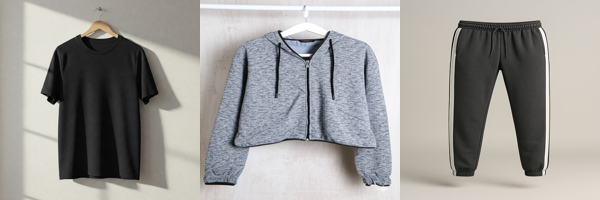

In [131]:
main()

✨ Enter your outfit preferences (e.g., casual, formal, sporty) or press Enter to skip: casual
🎉 Enter the occasion (e.g., wedding, office, gym): beach party
🌆 Enter your city to fetch the weather (or press Enter to skip): vancouver
🌍 Enter your country to fetch the weather (or press Enter to skip): canada
⛅ Scanning the skies for your weather update...
🧠 Gemini is putting together the perfect look for you...


🧵 Here's your outfit recommendation:
Okay, I can help you with a casual outfit for a beach party.

Given the weather in Vancouver is a bit cool with few clouds, I'll recommend something that will keep you comfortable.

I would recommend the following outfit:

*   A white long-sleeve linen shirt (image 3). This is lightweight and breathable, perfect for a beach party.
*   Pair it with khaki shorts (image 11) for a relaxed, beachy look.


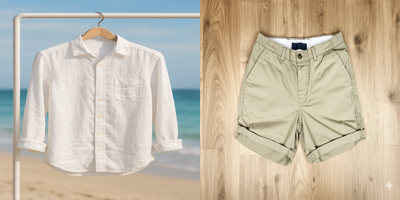

In [124]:
main()

✨ Enter your outfit preferences (e.g., casual, formal, sporty) or press Enter to skip: semi-formals
🎉 Enter the occasion (e.g., wedding, office, gym): dinner date
🌆 Enter your city to fetch the weather (or press Enter to skip): 
🌍 Enter your country to fetch the weather (or press Enter to skip): 
⛅ Skipping weather check...
🧠 Gemini is putting together the perfect look for you...


🧵 Here's your outfit recommendation:
Okay, I understand. Given your preference for semi-formal attire and the occasion being a dinner date, I will suggest an outfit for you.

I would recommend pairing the navy blue long sleeve shirt (image 16) with the black dress pants (image 17).

This combination offers a sophisticated yet relaxed semi-formal look that is perfect for a dinner date. The navy blue shirt adds a touch of color and elegance, while the black dress pants keep the outfit grounded and stylish.


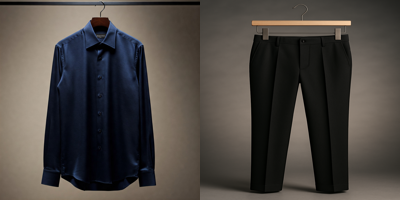

In [125]:
main()

## More interesting demos here 👇

- [Analyze a Video - Summarization 🎥](https://github.com/google-gemini/cookbook/blob/main/examples/Analyze_a_Video_Summarization.ipynb)

- [Illustrating a book using Imagen 3 🌌](https://github.com/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb)

- [Guess the shape: Triangle, square, pentagon,? 💭](https://github.com/google-gemini/cookbook/blob/main/examples/Guess_the_shape.ipynb)
